In [64]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import ruamel.yaml
import math
import numpy as np
import tarfile
from matplotlib import cm
from matplotlib import pyplot as plt
import warnings
import yaml
yaml_format = ruamel.yaml.YAML()
warnings.filterwarnings('ignore')
from matplotlib.ticker import FuncFormatter  # Add this import at the top
import pickle  # Add this import at the top



import matplotlib.ticker as ticker  # Add this import at the top


In [65]:
def get_data_dir(subfolder):
    # current_dir = os.path.dirname(os.path.abspath(__file__))
    current_dir = os.getcwd()
    print(current_dir)
    return os.path.join(current_dir, "experiment_data", subfolder)


In [66]:
def derived_papi(PAPI_data):
    DERIVED = {}
    DERIVED['TOT_INS_PER_CYC'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_TOT_INS']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_TOT_INS'].time)
    })
    DERIVED['TOT_CYC_PER_INS'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_INS']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_TOT_CYC'].time)
    })
    DERIVED['L3_TCM_PER_TCA'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_L3_TCM']['instantaneous_value']) / np.array(PAPI_data['PAPI_L3_TCA']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_L3_TCM'].time)
    })  
    DERIVED['TOT_STL_PER_CYC'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_RES_STL']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_RES_STL'].time)
    })
    
    # Create a mask for non-NaN values across all keys
    mask = ~DERIVED['TOT_INS_PER_CYC']['value'].isna()  # Start with one key to create the mask
    for key in DERIVED:
        mask &= ~DERIVED[key]['value'].isna()  # Combine masks for all keys

    for key in DERIVED:
        DERIVED[key] = DERIVED[key][mask]  # Filter each DataFrame using the combined mask

    return DERIVED

def collect_power(power_data):
    power={}
    power['geopm_0'] = power_data[power_data.scope==0]
    power['geopm_1'] = power_data[power_data.scope==1]
    power['geopm_0']['elapsed_time'] = power['geopm_0']['time'] - power['geopm_0']['time'].iloc[0]
    power['geopm_1']['elapsed_time'] = power['geopm_1']['time'] - power['geopm_1']['time'].iloc[0]
    
    min_length = min(len(power['geopm_0']), len(power['geopm_1']))
    geopm_power_0 = power['geopm_0'][:min_length]
    geopm_power_1 = power['geopm_1'][:min_length]

    average_power = pd.DataFrame({
        'time_stamp': geopm_power_0['time'],  # Use the timestamp from geopm_power_0
        'average_power': [(p0 + p1) / 2 for p0, p1 in zip(geopm_power_0['value'], geopm_power_1['value'])]
    })
    average_power['elapsed_time'] = power['geopm_0']['elapsed_time']
    power['average_power'] = average_power
    return power

def calculate_power_with_wraparound(current, previous, time_diff, wraparound_value=262143.328850):
    diff = current - previous
    if diff < 0:  # Wraparound detected
        diff = (wraparound_value - previous) + current
    return diff / time_diff

def compute_power(pubEnergy,power_data=None):
    power = {}
    geopm_sensor0 = geopm_sensor1 = pd.DataFrame({'timestamp':[],'value':[]})
    for i,row in pubEnergy.iterrows():
        if i%2 == 0:
            geopm_sensor0 = pd.concat([geopm_sensor0, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)
        else:
            geopm_sensor1 = pd.concat([geopm_sensor1, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)


    power['geopm_power_0'] = pd.DataFrame({
        'timestamp': geopm_sensor0['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor0['value'][i],
                geopm_sensor0['value'][i-1],
                geopm_sensor0['timestamp'][i] - geopm_sensor0['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor0))
        ]
    })

    # Apply the same logic to geopm_power_1
    power['geopm_power_1'] = pd.DataFrame({
        'timestamp': geopm_sensor1['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor1['value'][i],
                geopm_sensor1['value'][i-1],
                geopm_sensor1['timestamp'][i] - geopm_sensor1['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor1))
        ]
    })

    min_length = min(len(power['geopm_power_0']), len(power['geopm_power_1']))
    geopm_power_0 = power['geopm_power_0'][:min_length]
    geopm_power_1 = power['geopm_power_1'][:min_length]
    # fig,axs = plt.subplots(3,1)
    # axs[0].plot(geopm_power_0['timestamp'], geopm_power_0['power'], label='Node 0')
    # axs[1].plot(geopm_power_1['timestamp'], geopm_power_1['power'], label='Node 1')

    average_power = pd.DataFrame({
        'timestamp': geopm_power_0['timestamp'],  # Use the timestamp from geopm_power_0
        'average_power': [(p0 + p1) / 2 for p0, p1 in zip(geopm_power_0['power'], geopm_power_1['power'])]
    })
    average_power['elapsed_time'] = average_power['timestamp'] - average_power['timestamp'].iloc[0]
    # axs[2].plot(average_power['timestamp'], average_power['average_power'], label='Average Power', color='green')
    power['average_power'] = average_power
    return power

def measure_progress(progress_data, energy_data):
    Progress_DATA = {} 
    progress_sensor = pd.DataFrame(progress_data)
    first_sensor_point = min(energy_data['average_power']['timestamp'].iloc[0], progress_sensor['time'][0])
    progress_sensor['elapsed_time'] = progress_sensor['time'] - first_sensor_point  # New column for elapsed time
    # progress_sensor = progress_sensor.set_index('elapsed_time')
    performance_elapsed_time = progress_sensor.elapsed_time
    # Add performance_frequency as a new column in progress_sensor
    frequency_values = [
        progress_data['value'].iloc[t] / (performance_elapsed_time[t] - performance_elapsed_time[t-1]) for t in range(1, len(performance_elapsed_time))
    ]
    
    # Ensure the frequency_values length matches the index length
    frequency_values = [0] + frequency_values  # Prepend a 0 for the first index
    progress_sensor['frequency'] = frequency_values
    upsampled_timestamps= energy_data['average_power']['timestamp']
    
    # true_count = (progress_sensor['time'] <= upsampled_timestamps.iloc[0]).sum()

    progress_frequency_median = pd.DataFrame({'median': np.nanmedian(progress_sensor['frequency'].where(progress_sensor['time'] <= upsampled_timestamps.iloc[0])), 'timestamp': upsampled_timestamps.iloc[0]}, index=[0])
    for t in range(1, len(upsampled_timestamps)):
        progress_frequency_median = pd.concat([progress_frequency_median, pd.DataFrame({'median': [np.nanmedian(progress_sensor['frequency'].where((progress_sensor['time'] >= upsampled_timestamps.iloc[t-1]) & (progress_sensor['time'] <= upsampled_timestamps.iloc[t])))],
        'timestamp': [upsampled_timestamps.iloc[t]]})], ignore_index=True)
    progress_frequency_median['elapsed_time'] = progress_frequency_median['timestamp'] - progress_frequency_median['timestamp'].iloc[0]
    # Assign progress_frequency_median as a new column
    Progress_DATA['progress_sensor'] = progress_sensor
    Progress_DATA['progress_frequency_median'] = progress_frequency_median
    return Progress_DATA

def collect_papi(PAPI_data):
    PAPI = {}
    for scope in PAPI_data['scope'].unique():
        # Extract the string between the 3rd and 4th dots
        scope_parts = scope.split('.')
        if len(scope_parts) > 4:  # Ensure there are enough parts
            extracted_scope = scope_parts[3]
            # Aggregate the data for the extracted scope using pd.concat
            PAPI[extracted_scope] = PAPI_data[PAPI_data['scope'] == scope]
            instantaneous_values = [0] + [PAPI[extracted_scope]['value'].iloc[k] - PAPI[extracted_scope]['value'].iloc[k-1] for k in range(1,len(PAPI[extracted_scope]))]
            # Normalize the instantaneous values between 0 and 10
            # min_val = min(instantaneous_values)
            # max_val = max(instantaneous_values)
            PAPI[extracted_scope]['instantaneous_value'] = instantaneous_values
            PAPI[extracted_scope]['elapsed_time'] = PAPI[extracted_scope]['time'] - PAPI[extracted_scope]['time'].iloc[0]
    return PAPI


def generate_PCAP(PCAP_data):
    for row in PCAP_data.iterrows():
        if row[1]['time'] == 0:
            PCAP_data = PCAP_data.drop(row[0])


    PCAP_data['elapsed_time'] = PCAP_data['time'] - PCAP_data['time'].iloc[0]
    return PCAP_data


def compute_energy_consump(test_data_frame):
    total_energy = 0
    for i,t in enumerate(test_data_frame['average_power']['elapsed_time'].iloc[:-1]):
        total_energy += test_data_frame['average_power']['average_power'].iloc[i] * (test_data_frame['average_power']['elapsed_time'].iloc[i+1]-test_data_frame['average_power']['elapsed_time'].iloc[i])
    return total_energy


In [67]:
# #### Uncomment this to see the time log plots of prgress and power
# plt.rcParams.update({'font.size': 8, "font.weight": "bold", 'axes.labelsize': 'large', 'axes.labelweight': 'bold'})

# def compute_energy_consump(test_data_frame):
#     total_energy = 0
#     for i,t in enumerate(test_data_frame['average_power']['elapsed_time'].iloc[:-1]):
#         total_energy += test_data_frame['average_power']['average_power'].iloc[i] * (test_data_frame['average_power']['elapsed_time'].iloc[i+1]-test_data_frame['average_power']['elapsed_time'].iloc[i])
#     return total_energy

# fig_phase,axs_phase = plt.subplots(3,1, figsize=(10, 8))
# experiments = {'data_generation':'k', 'Control':'r'}
# for dirs in experiments.keys():
#     if 'data' in dirs:
#         label_val = "Uncapped"
#     elif 'Control' in dirs:
#         label_val = "Proposed Controller"
#     DATA_DIR = get_data_dir(dirs)
#     root,folders,files = next(os.walk(DATA_DIR))
#     test_results = {}
#     for APP in folders:
#         APP_DIR = os.path.join(DATA_DIR, APP)
#         test_results[APP] = {}
#         print(next(os.walk(APP_DIR)))
#         for tar_file in next(os.walk(APP_DIR))[2]:
#             test_results[APP][tar_file] = {}
#             if tar_file.endswith('.tar'):
#                 tar_path = os.path.join(APP_DIR,tar_file)
#                 extract_dir = os.path.join(APP_DIR,tar_file[:-4])  
#                 print("------",tar_path)
#                 if not os.path.exists(extract_dir):
#                     os.makedirs(extract_dir)
                
#                 with tarfile.open(tar_path, 'r') as tar:
#                     tar.extractall(path=extract_dir)
            
#             pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
#             pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
#             pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
#             pubPCAP = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
#             pubPower = pd.read_csv(f'{extract_dir}/measured_power.csv')
#             test_results[APP][tar_file]['energy'] = pubEnergy
#             test_results[APP][tar_file]['power'] = compute_power(pubEnergy)
#             test_results[APP][tar_file]['progress'] = measure_progress(pubProgress,test_results[APP][tar_file]['power'])
#             test_results[APP][tar_file]['papi'] = collect_papi(pubPAPI)
#             test_results[APP][tar_file]['PCAP'] = generate_PCAP(pubPCAP)
#             test_results[APP][tar_file]['derived_papi'] = derived_papi(test_results[APP][tar_file]['papi'])   
#             test_results[APP][tar_file]['sensed_power'] = collect_power(pubPower)
#             stop = -1
#             lw = 10
#             # print(test_results[APP][tar_file])
#             computed_energy = compute_energy_consump(test_results[APP][tar_file]['power'])
#             print("Total Energy consumed: ", computed_energy)
#             print("Total Execution Time: ", test_results[APP][tar_file]['energy'].time.iloc[-1]-test_results[APP][tar_file]['energy'].time.iloc[0])
#             axs_phase[0].scatter(test_results[APP][tar_file]['progress']['progress_frequency_median']['elapsed_time'].iloc[:stop],test_results[APP][tar_file]['progress']['progress_frequency_median']['median'].iloc[:stop],s=lw,label=f'{label_val}')
#             # axs_phase[1].scatter(test_results[APP][tar_file]['power']['average_power']['elapsed_time'].iloc[:stop],test_results[APP][tar_file]['power']['average_power']['average_power'].iloc[:stop],s=lw,label=f'{label_val}')
#             axs_phase[1].scatter(test_results[APP][tar_file]['sensed_power']['average_power']['elapsed_time'],test_results[APP][tar_file]['sensed_power']['average_power']['average_power'],s=lw,label=f'{label_val}')
#             axs_phase[2].scatter(test_results[APP][tar_file]['PCAP']['elapsed_time'].values[:stop],test_results[APP][tar_file]['PCAP']['value'].values[:stop],s=lw,label=f'{label_val}')

#             axs_phase[2].set_xlabel("Time [s]")
#             axs_phase[0].set_ylabel("Progress [Hz]")
#             axs_phase[0].grid(True)
#             axs_phase[1].set_ylabel("Measured Power [W]")
#             axs_phase[1].grid(True)
#             axs_phase[2].set_ylabel("PCAP [W]")
#             axs_phase[2].grid(True)
# handles, labels = axs_phase[0].get_legend_handles_labels()
# unique_labels = dict(zip(labels, handles))  # Create a dictionary to keep unique labels
# fig_phase.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', bbox_to_anchor=(0.9, 0.75), bbox_transform=fig_phase.transFigure)
# plt.savefig(f'{APP}.pdf', format='pdf', bbox_inches='tight') 
# plt.tight_layout()


In [68]:
#### Uncomment this to see the time log plots of prgress and power



In [69]:
# DATA_DIR = get_data_dir('data_generation')
# root,folders,files = next(os.walk(DATA_DIR))
# test_results = {}
# for APP in folders:
#     APP_DIR = os.path.join(DATA_DIR, APP)
#     test_results[APP] = {}
#     for file in next(os.walk(APP_DIR))[1]:
#         tar_dir = os.path.join(APP_DIR, file)
#         test_results[APP][file] = {}
#         for tar_file in next(os.walk(tar_dir))[2]:
#             test_results[APP][file][tar_file] = {}
#             if tar_file.endswith('.tar'):
#                 tar_path = os.path.join(tar_dir, tar_file)
#                 extract_dir = os.path.join(tar_dir, tar_file[:-4])  
                
#                 if not os.path.exists(extract_dir):
#                     os.makedirs(extract_dir)
                
#                 with tarfile.open(tar_path, 'r') as tar:
#                     tar.extractall(path=extract_dir)
            
#             pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
#             pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
#             pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
#             pubPCAP = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
#             pubPower = pd.read_csv(f'{extract_dir}/measured_power.csv')

#             test_results[APP][file][tar_file]['energy'] = pubEnergy
#             test_results[APP][file][tar_file]['power'] = compute_power(pubEnergy)
#             test_results[APP][file][tar_file]['progress'] = measure_progress(pubProgress,test_results[APP][file][tar_file]['power'])
#             test_results[APP][file][tar_file]['papi'] = collect_papi(pubPAPI)
#             test_results[APP][file][tar_file]['PCAP'] = generate_PCAP(pubPCAP)
#             test_results[APP][file][tar_file]['derived_papi'] = derived_papi(test_results[APP][file][tar_file]['papi'])   
#             test_results[APP][file][tar_file]['pubPower'] = pubPower
# print(test_results[APP][file][tar_file])

In [70]:
DATA_DIR = get_data_dir('data_generation_backup')
root,folders,files = next(os.walk(DATA_DIR))
test_results = {}
for APP in folders:
    APP_DIR = os.path.join(DATA_DIR, APP)
    test_results[APP] = {}
    for tar_file in next(os.walk(APP_DIR))[2]:
        test_results[APP][tar_file] = {}
        if tar_file.endswith('.tar'):
            tar_path = os.path.join(APP_DIR, tar_file)
            extract_dir = os.path.join(APP_DIR, tar_file[:-4])  
            
            if not os.path.exists(extract_dir):
                os.makedirs(extract_dir)
            
            with tarfile.open(tar_path, 'r') as tar:
                tar.extractall(path=extract_dir)
        
        pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
        pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
        pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
        pubPCAP = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
        pubPower = pd.read_csv(f'{extract_dir}/measured_power.csv')

        test_results[APP][tar_file]['energy'] = pubEnergy
        test_results[APP][tar_file]['power'] = compute_power(pubEnergy)
        test_results[APP][tar_file]['progress'] = measure_progress(pubProgress,test_results[APP][tar_file]['power'])
        test_results[APP][tar_file]['papi'] = collect_papi(pubPAPI)
        test_results[APP][tar_file]['PCAP'] = generate_PCAP(pubPCAP)
        test_results[APP][tar_file]['derived_papi'] = derived_papi(test_results[APP][tar_file]['papi'])   
        test_results[APP][tar_file]['pubPower'] = pubPower
# print(test_results[APP][tar_file])

/home/cc/summer2024/main_codes


In [71]:
metrics = {}
for app in test_results.keys():
    metrics[app] = {}
    metrics[app]['ET'] = []
    metrics[app]['IPC'] = []
    metrics[app]['progress'] = []
    metrics[app]['STL'] = []
    metrics[app]['CMR'] = []
    metrics[app]['ENERGY'] = []
    for trace in test_results[app].keys():
        if test_results[app][trace]['PCAP'].value.mean() > 164:
            metrics[app]['ET'].append(test_results[app][trace]['power']['average_power']['elapsed_time'].iloc[-1])
            metrics[app]['IPC'].append(test_results[app][trace]['derived_papi']['TOT_INS_PER_CYC'].value.mean())
            metrics[app]['STL'].append(test_results[app][trace]['derived_papi']['TOT_STL_PER_CYC'].value.mean())
            metrics[app]['CMR'].append(test_results[app][trace]['derived_papi']['L3_TCM_PER_TCA'].value.mean())
            metrics[app]['progress'].append(test_results[app][trace]['progress']['progress_frequency_median']['median'].mean())
            metrics[app]['ENERGY'].append(compute_energy_consump(test_results[app][trace]['power'])/1000)
    for para in metrics[app].keys():
        print(f"{app}-----------------{para}.................{np.mean(metrics[app][para])}")

ones-npb-is-----------------ET.................119.99998092651367
ones-npb-is-----------------IPC.................0.49652860877453137
ones-npb-is-----------------progress.................8.422176776805179
ones-npb-is-----------------STL.................0.6722859754350677
ones-npb-is-----------------CMR.................0.8613742691712418
ones-npb-is-----------------ENERGY.................19.473114118803412
ones-stream-add-----------------ET.................48.99957346916199
ones-stream-add-----------------IPC.................0.141579557712592
ones-stream-add-----------------progress.................204.76101964160037
ones-stream-add-----------------STL.................0.8543003728185232
ones-stream-add-----------------CMR.................0.9344106662190763
ones-stream-add-----------------ENERGY.................7.879994503310233
phases-stream-full-----------------ET.................85.99976921081543
phases-stream-full-----------------IPC.................0.1938989153712062
phases-stream-f

In [72]:
def compute_energy_consump(test_data_frame):
    total_energy = 0
    for i,t in enumerate(test_data_frame['average_power']['elapsed_time'].iloc[:-1]):
        total_energy += test_data_frame['average_power']['average_power'].iloc[i] * (test_data_frame['average_power']['elapsed_time'].iloc[i+1]-test_data_frame['average_power']['elapsed_time'].iloc[i])
    return total_energy

DATA_DIR = get_data_dir('Control_backup')
root,folders,files = next(os.walk(DATA_DIR))
test_results_control = {}
for APP in folders:
    APP_DIR = os.path.join(DATA_DIR, APP)
    test_results_control[APP] = {}
    for file in next(os.walk(APP_DIR))[2]:
        test_results_control[APP][file] = {}
        if file.endswith('.tar'):
            tar_path = os.path.join(APP_DIR, file)
            extract_dir = os.path.join(APP_DIR, file[:-4])  
            
            if not os.path.exists(extract_dir):
                os.makedirs(extract_dir)
            
            with tarfile.open(tar_path, 'r') as tar:
                tar.extractall(path=extract_dir)
            
        pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
        pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
        pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
        pubPCAP = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
        pubPower = pd.read_csv(f'{extract_dir}/measured_power.csv')
        test_results_control[APP][file]['energy'] = pubEnergy
        test_results_control[APP][file]['power'] = compute_power(pubEnergy,power_data=pubPower)
        test_results_control[APP][file]['progress'] = measure_progress(pubProgress,test_results_control[APP][file]['power'])
        test_results_control[APP][file]['papi'] = collect_papi(pubPAPI)
        test_results_control[APP][file]['PCAP'] = generate_PCAP(pubPCAP)
        test_results_control[APP][file]['derived_papi'] = derived_papi(test_results_control[APP][file]['papi'])   
        test_results_control[APP][file]['pubPower'] = pubPower


/home/cc/summer2024/main_codes


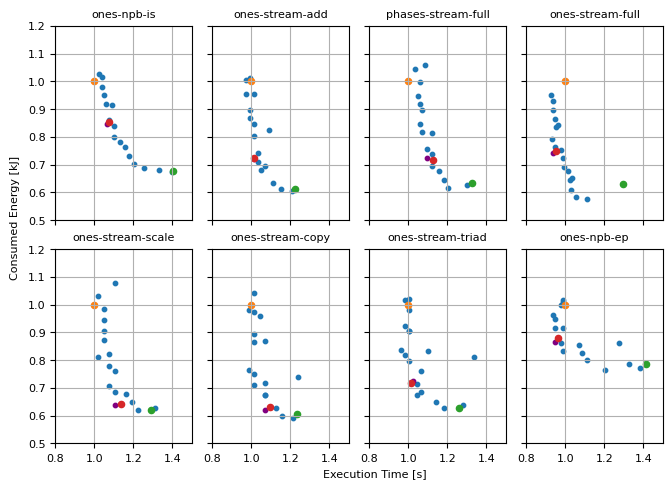

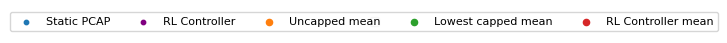

In [94]:
# print(test_results)


high_contrast_colors = plt.cm.tab10.colors[:5]
marker_size = 20
num_rows = 2
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols)
plt.rcParams.update({'font.size': 8, "font.weight": "normal", 'axes.labelsize': 'small'})
# plt.tight_layout()
plt.subplots_adjust(hspace=0.15, wspace=0.15, top=0.9, bottom=0.03, left=0.001, right=0.95)  # Adjust the spacing between subplots
fig.text(0.5, -0.04, 'Execution Time [s]', ha='center', fontsize=8)
fig.text(-0.07, 0.5, 'Consumed Energy [kJ]', va='center', rotation='vertical', fontsize=8)
index = 0

STATS = pd.read_csv('stats_summary.csv')

for app in test_results.keys():
    app_stats = STATS[STATS['Application'] == app]
    normalize_time = app_stats[(app_stats['Configuration'] == 'MAX') & (app_stats['Parameter'] == "ET")]["Mean"].reset_index(drop=True)
    normalize_energy = app_stats[(app_stats['Configuration'] == 'MAX') & (app_stats['Parameter'] == "ENERGY")]["Mean"].reset_index(drop=True)
    for trace in test_results[app].keys():
        # print(f"App: {app}")
        # print("Total execution time is: ", test_results[app][trace][tar_file]['power']['average_power']['elapsed_time'].iloc[-1])
        # print("Total energy consumed is: ", test_results[app][trace][tar_file]['power']['average_power']['average_power'].sum())
        computed_energy = compute_energy_consump(test_results[app][trace]['power'])/1000
        axs[index//num_cols, index%num_cols].scatter(test_results[app][trace]['power']['average_power']['elapsed_time'].iloc[-1]/normalize_time,computed_energy/normalize_energy, color=high_contrast_colors[0], s=10, label = "Static PCAP")
    # Format x-ticks and y-ticks
        # if 'ones-stream-full' in app or 'ones-npb-ep' in app  and computed_energy/normalize_energy > 1.2:
        #     print(app,trace)
            
    axs[index//num_cols, index%num_cols].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Change format as needed
    # y_formatter = ticker.ScalarFormatter(useMathText=False)  # Use ScalarFormatter for scientific notation
    # y_formatter.set_powerlimits((-3, 4))  # Set limits for scientific notation display
    # axs[index//num_cols, index%num_cols].yaxis.set_major_formatter(y_formatter)  # Apply the formatter
    axs[index//num_cols, index%num_cols].set_title(app, fontsize=8, loc='center')
    axs[index//num_cols, index%num_cols].grid(True)

    index += 1

# stats = pd.read_csv('stats_summary.csv')

index = 0
for app in test_results_control.keys():
    app_stats = STATS[STATS['Application'] == app]
    normalize_time = app_stats[(app_stats['Configuration'] == 'MAX') & (app_stats['Parameter'] == "ET")]["Mean"].reset_index(drop=True)
    normalize_energy = app_stats[(app_stats['Configuration'] == 'MAX') & (app_stats['Parameter'] == "ENERGY")]["Mean"].reset_index(drop=True)
    for trace in test_results_control[app].keys():
        # print(f"App: {app}")
        # print("Total execution time is: ", test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1])
        # print("Total energy consumed is: ", test_results_control[app][trace]['power']['average_power']['average_power'].sum())
        computed_energy = compute_energy_consump(test_results_control[app][trace]['power'])/1000
        axs[index//num_cols, index%num_cols].scatter(test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1]/normalize_time, computed_energy/normalize_energy, color='#800080', s=10, label = "RL Controller")
        axs[index//num_cols, index%num_cols].yaxis.set_major_formatter(FuncFormatter(lambda x, _: round(x, 1)))    
        axs[index//num_cols, index%num_cols].xaxis.set_major_formatter(FuncFormatter(lambda x, _: round(x, 1)))  
        axs[index//num_cols, index%num_cols].set_ylim(bottom=0.5,top=1.2)
        axs[index//num_cols, index%num_cols].set_xlim(left=0.8, right=1.5)
        axs[index//num_cols, index%num_cols].scatter(app_stats[(app_stats['Configuration'] == 'MAX') & (app_stats['Parameter'] == "ET")]["Mean"].reset_index(drop=True)/normalize_time, app_stats[(app_stats['Configuration'] == 'MAX') & (app_stats['Parameter'] == "ENERGY")]["Mean"].reset_index(drop=True)/normalize_energy, color=high_contrast_colors[1], s=marker_size, label = "Uncapped mean")
        axs[index//num_cols, index%num_cols].scatter(app_stats[(app_stats['Configuration'] == 'MIN') & (app_stats['Parameter'] == "ET")]["Mean"].reset_index(drop=True)/normalize_time, app_stats[(app_stats['Configuration'] == 'MIN') & (app_stats['Parameter'] == "ENERGY")]["Mean"].reset_index(drop=True)/normalize_energy, color=high_contrast_colors[2], s=marker_size, label = "Lowest capped mean")
        axs[index//num_cols, index%num_cols].scatter(app_stats[(app_stats['Configuration'] == 'OPT') & (app_stats['Parameter'] == "ET")]["Mean"].reset_index(drop=True)/normalize_time, app_stats[(app_stats['Configuration'] == 'OPT') & (app_stats['Parameter'] == "ENERGY")]["Mean"].reset_index(drop=True)/normalize_energy, color=high_contrast_colors[3], s=marker_size, label = "RL Controller mean")
    # Format x-ticks and y-ticks
    # axs[index//3, index%3].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Change format as needed
    # y_formatter = ticker.ScalarFormatter(useMathText=False)  # Use ScalarFormatter for scientific notation
    # y_formatter.set_powerlimits((-3, 4))  # Set limits for scientific notation display
    # axs[index//3, index%3].yaxis.set_major_formatter(y_formatter)  # Apply the formatter
    # axs[index//3, index%3].set_title(app)
    # axs[index//3, index%3].grid(True)
    index += 1


# for ax in axs.flat:
#     ax.set_xlim(min(test_results[app][trace]['power']['average_power']['elapsed_time'].iloc[-1]for app in test_results.keys() for trace in test_results[app].keys()), max(test_results[app][trace]['power']['average_power']['elapsed_time'].iloc[-1] for app in test_results.keys() for trace in test_results[app].keys()))
# plt.tight_layout()
# plt.show()
# stats = pd.read_csv('stats.csv')
# for row in stats.iterrows():
#     print(row)

# Load the dictionaries from the exported file

handles, labels = axs[0,0].get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Create a dictionary to keep unique labels    
# fig.legend(unique_labels.values(), unique_labels.keys(), loc='lower right', bbox_to_anchor=(0.95, 0.1))

for i in range(num_rows):
    for j in range(num_cols):
        if j > 0:
            axs[i, j].set_yticklabels([])
        if i == 0:
            axs[i, j].set_xticklabels([])
plt.savefig('comparison.pdf', format='pdf', bbox_inches='tight')  # Save the figure

fig_leg, ax_leg = plt.subplots(figsize=(8.5,0.3))
# Create dummy plots for legend entries
# line1, = ax.plot([], [], label='Static PCAP', color='k')  # Dummy line for Static PCAP
# line2, = ax.plot([], [], label='Proposed Controller', color='r')  # Dummy line for Proposed Controller
# line3, = ax.plot([], [], label='Proposed Controller', color='r')  # Dummy line for Proposed Controller
# line4, = ax.plot([], [], label='Proposed Controller', color='r')  # Dummy line for Proposed Controller
# line5, = ax.plot([], [], label='Proposed Controller', color='r')  # Dummy line for Proposed Controller


# Set limits to avoid displaying any data
ax_leg.set_xlim(0, 1)
ax_leg.set_ylim(0, 1)

# Add legend
ax_leg.legend(loc='center')

# Remove axes
ax_leg.axis('off')
fig_leg.legend(unique_labels.values(), unique_labels.keys(), loc='center', ncol=5)

# Save the figure
plt.savefig('legend_only.pdf', format='pdf', bbox_inches='tight')
plt.show()



In [63]:
stats = {}
for app in test_results.keys():
    stats[app] = {}
    stats[app]["MAX"] = {}
    stats[app]["MIN"] = {}
    stats[app]["MAX"]['ET'] = []
    stats[app]["MAX"]['ENERGY'] = []
    stats[app]["MIN"]['ET'] = []
    stats[app]["MIN"]['ENERGY'] = []
    for trace in test_results[app].keys():
        if test_results[app][trace]['PCAP'].value.mean() > 164:
            exp = "MAX"
        else:
            exp = "MIN"
        # print(exp)
        stats[app][exp]['ET'].append(test_results[app][trace]['power']['average_power']['elapsed_time'].iloc[-1])
        stats[app][exp]['ENERGY'].append(compute_energy_consump(test_results[app][trace]['power'])/1000)
# for app in stats.keys():
#     for exp in stats[app].keys():
#         for para in stats[app][exp].keys(): 
#             print(f"{app}-----{exp}-----{para}.................{np.mean(stats[app][exp][para])}--------------------{np.std(stats[app][exp][para])}")
                    
# stats = {}
for app in test_results_control.keys():
    # stats[app] = {}
    stats[app]["OPT"] = {}
    stats[app]["OPT"] = {}
    stats[app]["OPT"]['ET'] = []
    stats[app]["OPT"]['ENERGY'] = []
    for trace in test_results_control[app].keys():
        stats[app]["OPT"]['ET'].append(test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1])
        stats[app]["OPT"]['ENERGY'].append(compute_energy_consump(test_results_control[app][trace]['power'])/1000)
MAX = {}
MIN = {}
RL = {}
for app in stats.keys():
    for exp in stats[app].keys():
        for para in stats[app][exp].keys(): 
            # stats[app][exp][para]['mean'] = np.mean(stats[app][exp][para])
            # stats[app][exp][para]['std'] = np.std(stats[app][exp][para])
            print(f"{app}-----{exp}-----{para}................mean:{np.mean(stats[app][exp][para])}--------------------std:{np.std(stats[app][exp][para])}")
            if exp == "MAX":
                MAX[app] = (np.mean(stats[app][exp][para]),np.std(stats[app][exp][para]))
            elif exp == "MIN":
                MIN[app] = (np.mean(stats[app][exp][para]),np.std(stats[app][exp][para]))
            elif exp == "OPT":
                RL[app] = (np.mean(stats[app][exp][para]),np.std(stats[app][exp][para]))
            else:
                print("Something wrong")
            

import pickle  # Add this import at the top

with open('stats_export.pkl', 'wb') as f:  # Export to a file named 'stats_export.pkl'
    pickle.dump({'MAX': MAX, 'MIN': MIN, 'RL': RL}, f)  # Save the dictionaries

stats_list = []

for app in stats.keys():
    for exp in stats[app].keys():
        for param in stats[app][exp].keys():
            mean_value = np.mean(stats[app][exp][para])
            std_value = np.std(stats[app][exp][para])
            # print(mean_value,std_value)
            stats_list.append({
                'App': app,
                'Type': exp,
                'Parameter': param,
                'Mean': mean_value,
                'Std': std_value
            })

# Convert the list of dictionaries to a DataFrame
stats_df = pd.DataFrame(stats_list)

# Saving the DataFrame to a CSV file
stats_df.to_csv('stats_summary.csv', index=False)   

ones-npb-is-----MAX-----ET................mean:117.3334231376648--------------------std:1.2471551756190637
ones-npb-is-----MAX-----ENERGY................mean:18.990811878502505--------------------std:0.1567935709695871
ones-npb-is-----MIN-----ET................mean:164.75017857551575--------------------std:1.2989935807182609
ones-npb-is-----MIN-----ENERGY................mean:12.83080043098968--------------------std:0.12589368216638738
ones-npb-is-----OPT-----ET................mean:125.80014207363129--------------------std:0.9797736080759653
ones-npb-is-----OPT-----ENERGY................mean:16.178328539347692--------------------std:0.13617700541032915
ones-stream-add-----MAX-----ET................mean:50.39988160133362--------------------std:2.615444889353019
ones-stream-add-----MAX-----ENERGY................mean:7.843785766481984--------------------std:0.3668646796045452
ones-stream-add-----MIN-----ET................mean:61.55554543601142--------------------std:0.955879934943381
ones-

In [2]:
# print(test_results)

high_contrast_colors = plt.cm.tab10.colors[:4]
markersize = 50

def compute_energy_consump(test_data_frame):
    total_energy = 0
    for i,t in enumerate(test_data_frame['average_power']['elapsed_time'].iloc[:-1]):
        total_energy += test_data_frame['average_power']['average_power'].iloc[i] * (test_data_frame['average_power']['elapsed_time'].iloc[i+1]-test_data_frame['average_power']['elapsed_time'].iloc[i])
    return total_energy


# fig, axs = plt.subplots(2, 4)
plt.rcParams.update({'font.size': 10, "font.weight": "bold", 'axes.labelsize': 'large', 'axes.labelweight': 'bold'})
# plt.rcParams.update({'font.size': 8, "font.weight": "bold", 'axes.labelsize': 'x-large'})
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.2, wspace=0.2, top=0.9, bottom=0.03, left=0.02, right=0.95)  # Adjust the spacing between subplots
# fig.text(0.5, -0.04, 'Execution Time', ha='center', fontsize=10)
# fig.text(-0.05, 0.5, 'Consumed Energy', va='center', rotation='vertical', fontsize=10)
index = 0
for app in test_results.keys():
    fig_name = f'fig_{app}'  # Create a dynamic name for the figure
    ax_name = f'ax_{app}'    # Create a dynamic name for the axes
    locals()[fig_name], locals()[ax_name] = plt.subplots(1, 1, figsize=(10,3))  # Create a new subplot for each app
    # for trace in test_results[app].keys():
    for tar_file in test_results[app].keys():
        if test_results[app][tar_file]['power']['average_power']['average_power'].sum() > 30000:
            print(app,tar_file)
            
        # print(f"App: {app}")
        # print("Total execution time is: ", test_results[app][trace][tar_file]['power']['average_power']['elapsed_time'].iloc[-1])
        # print("Total energy consumed is: ", test_results[app][trace][tar_file]['power']['average_power']['average_power'].sum())
        computed_energy = compute_energy_consump(test_results[app][tar_file]['power'])
        locals()[ax_name].scatter(test_results[app][tar_file]['power']['average_power']['elapsed_time'].iloc[-1], computed_energy/1000, color=high_contrast_colors[0], s=markersize, label = "Static PCAP")

        # locals()[ax_name][1].scatter(test_results[app][tar_file]['power']['average_power']['elapsed_time'].iloc[-1], computed_energy*test_results[app][tar_file]['power']['average_power']['elapsed_time'].iloc[-1], color=high_contrast_colors[0], s=20, label="Static PCAP")
        # axs[index//4, index%4].scatter(test_results[app][tar_file]['power']['average_power']['elapsed_time'].iloc[-1], test_results[app][tar_file]['power']['average_power']['average_power'].sum())
# Format x-ticks and y-ticks
    # locals()[ax_name][0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Change format as needed
    # # y_formatter = ticker.ScalarFormatter(useMathText=False)  # Use ScalarFormatter for scientific notation
    # # y_formatter.set_powerlimits((-3, 4))  # Set limits for scientific notation display
    # # locals()[ax_name][0].yaxis.set_major_formatter(y_formatter)  # Apply the formatter
    # locals()[ax_name][0].set_title(app, fontsize=10, loc='right')
    # locals()[ax_name][0].grid(True)
    # locals()[ax_name][1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Change format as needed
    # y_formatter = ticker.ScalarFormatter(useMathText=False)  # Use ScalarFormatter for scientific notation
    # y_formatter.set_powerlimits((-3, 6))  # Set limits for scientific notation display
    # locals()[ax_name][0].yaxis.set_major_formatter(y_formatter)  # Apply the formatter
    # locals()[ax_name][1].yaxis.set_major_formatter(y_formatter)  # Apply the formatter
    # locals()[ax_name][1].set_title(app, fontsize=10, loc='right')
    # locals()[ax_name][1].grid(True)

    index += 1

# DATA_DIR = get_data_dir('Control')
# root,folders,files = next(os.walk(DATA_DIR))
# test_results_control = {}
# for APP in folders:
#     APP_DIR = os.path.join(DATA_DIR, APP)
#     test_results_control[APP] = {}
#     for file in next(os.walk(APP_DIR))[2]:
#         test_results_control[APP][file] = {}
#         if file.endswith('.tar'):
#             tar_path = os.path.join(APP_DIR, file)
#             extract_dir = os.path.join(APP_DIR, file[:-4])  
            
#             if not os.path.exists(extract_dir):
#                 os.makedirs(extract_dir)
            
#             with tarfile.open(tar_path, 'r') as tar:
#                 tar.extractall(path=extract_dir)
            
#         pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
#         pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
#         pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
#         pubPCAP = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
#         pubPower = pd.read_csv(f'{extract_dir}/measured_power.csv')
#         test_results_control[APP][file]['energy'] = pubEnergy
#         test_results_control[APP][file]['power'] = compute_power(pubEnergy,power_data=pubPower)
#         test_results_control[APP][file]['progress'] = measure_progress(pubProgress,test_results_control[APP][file]['power'])
#         test_results_control[APP][file]['papi'] = collect_papi(pubPAPI)
#         test_results_control[APP][file]['PCAP'] = generate_PCAP(pubPCAP)
#         test_results_control[APP][file]['derived_papi'] = derived_papi(test_results_control[APP][file]['papi'])   
#         test_results_control[APP][file]['pubPower'] = pubPower


index = 0
for app in test_results_control.keys():
    fig_name = f'fig_{app}'  # Create a dynamic name for the figure
    ax_name = f'ax_{app}'    # Create a dynamic name for the axes

    for trace in test_results_control[app].keys():
        # if test_results_control[app][trace]['power']['average_power']['average_power'].sum() < 5000:
        #     print(app,trace)
        # print(f"App: {app}")
        # print("Total execution time is: ", test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1])
        # print("Total energy consumed is: ", test_results_control[app][trace]['power']['average_power']['average_power'].sum())
        # locals()[ax_name][0].scatter(test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1], test_results_control[app][trace]['power']['average_power']['average_power'].sum(), color='green', s=20)
        # locals()[ax_name][1].scatter(test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1], test_results_control[app][trace]['power']['average_power']['average_power'].sum()*test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1], color='green', s=20)
        computed_energy = compute_energy_consump(test_results_control[app][trace]['power'])
        scatter_plot_0 = locals()[ax_name].scatter(test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1], computed_energy/1000 , color=high_contrast_colors[-1], s=markersize, label="Proposed Controller")
        # locals()[ax_name][0].text(
        #     test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1], 
        #     test_results_control[app][trace]['power']['average_power']['average_power'].sum(), 
        #     f'{trace[-10:]}', 
        #     fontsize=8, 
        #     verticalalignment='bottom', 
        #     horizontalalignment='left'
        # )
        
        # scatter_plot_1 = locals()[ax_name][1].scatter(test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1], computed_energy * test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1], color=high_contrast_colors[-1], s=20, label="Proposed Controller")
        # locals()[ax_name][1].text(
        #     test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1], 
        #     test_results_control[app][trace]['power']['average_power']['average_power'].sum()*test_results_control[app][trace]['power']['average_power']['elapsed_time'].iloc[-1], 
        #     f'{trace[-10:]}', 
        #     fontsize=8, 
        #     verticalalignment='bottom', 
        #     horizontalalignment='left'
        # )
    # Format x-ticks and y-ticks
    # axs[index//3, index%3].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Change format as needed
    # y_formatter = ticker.ScalarFormatter(useMathText=False)  # Use ScalarFormatter for scientific notation
    # y_formatter.set_powerlimits((-3, 4))  # Set limits for scientific notation display
    # axs[index//3, index%3].yaxis.set_major_formatter(y_formatter)  # Apply the formatter
    # axs[index//3, index%3].set_title(app)
    # axs[index//3, index%3].grid(True)
    index += 1
# plt.show()
    # locals()[ax_name][0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Change format as needed
    # y_formatter = ticker.ScalarFormatter(useMathText=False)  # Use ScalarFormatter for scientific notation
    # y_formatter.set_powerlimits((-3, 4))  # Set limits for scientific notation display
    # locals()[ax_name][0].yaxis.set_major_formatter(y_formatter)  # Apply the formatter
    # locals()[ax_name][0].set_title(app, fontsize=10, loc='right')
    locals()[ax_name].grid(True)
    # locals()[ax_name][1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Change format as needed
    # y_formatter = ticker.ScalarFormatter(useMathText=True)  # Use ScalarFormatter for scientific notation
    # y_formatter.set_powerlimits((-3, 6))  # Set limits for scientific notation display
    # locals()[ax_name][0].yaxis.set_major_formatter(y_formatter)  # Apply the formatter
    # locals()[ax_name][1].yaxis.set_major_formatter(y_formatter)  # Apply the formatter
    # locals()[ax_name][1].set_title(app, fontsize=10, loc='right')
    # locals()[ax_name][0].ticklabel_format(axis='both', style='sci', scilimits=(5,2))
    # locals()[ax_name][1].ticklabel_format(axis='both', style='sci', scilimits=(5,2))
    # locals()[ax_name][1].grid(True)
    # locals()[ax_name][0].set_xticks([])
    # locals()[ax_name][0].tick_params(labelbottom=False)
    locals()[ax_name].set_xlabel("Execution Time [s]")
    locals()[ax_name].set_ylabel("Energy Consumed [J]")
    locals()[ax_name].yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))  # Format y-axis ticks as integers

    # locals()[ax_name][1].set_ylabel("EDP values [Js]")
    handles, labels = locals()[ax_name].get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Create a dictionary to keep unique labels    
    locals()[fig_name].legend(unique_labels.values(), unique_labels.keys())
    plt.tight_layout()
    locals()[fig_name].savefig(f'repeat_{fig_name}.pdf', format='pdf', bbox_inches='tight')  # Save the figure

NameError: name 'plt' is not defined

In [ ]:
metrics = {}
for app in test_results.keys():
    metrics[app] = {}
    metrics[app]['ET'] = []
    metrics[app]['IPC'] = []
    metrics[app]['progress'] = []
    metrics[app]['STL'] = []
    metrics[app]['CMR'] = []
    for trace in test_results[app].keys():
        metrics[app]['ET'].append(test_results[app][trace]['power']['average_power']['elapsed_time'].iloc[-1])
        metrics[app]['IPC'].append(test_results[app][trace]['derived_papi']['TOT_INS_PER_CYC'].value.mean())
        metrics[app]['STL'].append(test_results[app][trace]['derived_papi']['TOT_STL_PER_CYC'].value.mean())
        metrics[app]['CMR'].append(test_results[app][trace]['derived_papi']['L3_TCM_PER_TCA'].value.mean())
        metrics[app]['progress'].append(test_results[app][trace]['progress']['progress_frequency_median']['median'].mean())
    for para in metrics[app].keys():
        print(f"{app}-----------------{para}.................{np.mean(metrics[app][para])}")
        
control_metrics = {}
for app in test_results_control.keys():
    control_metrics[app] = {}
    control_metrics[app]['ET'] = []
    control_metrics[app]['IPC'] = []
    control_metrics[app]['progress'] = []
    control_metrics[app]['STL'] = []
    control_metrics[app]['CMR'] = []
    for trace in test_results_control[app].keys():
        control_metrics[app]['ET'].append(test_results[app][trace]['power']['average_power']['elapsed_time'].iloc[-1])
        control_metrics[app]['IPC'].append(test_results[app][trace]['derived_papi']['TOT_INS_PER_CYC'].value.mean())
        control_metrics[app]['STL'].append(test_results[app][trace]['derived_papi']['TOT_STL_PER_CYC'].value.mean())
        control_metrics[app]['CMR'].append(test_results[app][trace]['derived_papi']['L3_TCM_PER_TCA'].value.mean())
        control_metrics[app]['progress'].append(test_results[app][trace]['progress']['progress_frequency_median']['median'].mean())
    for para in control_metrics[app].keys():
        print(f"{app}-----------------{para}.................{np.mean(metrics[app][para])}")

In [89]:
test_energy = compute_power(pubEnergy)


KeyError: 'compressed_iteration_20250109_222723.tar'

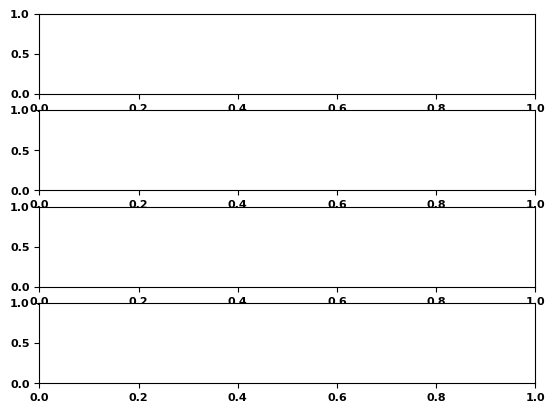

In [90]:
# print("test",test_results.keys())
# print("test",test_results_control.keys())

fig_test,axs_test = plt.subplots(4,1)
app = 'ones-stream-full'
file_t = 'compressed_iteration_20250109_222723.tar'
print(test_results_control[app][file_t]['power'].keys())
print(test_results_control[app][file_t]['power']['geopm_power_1'].keys())

# axs_test[0].scatter(test_results_control[app][file_t]['power']['average_power']['elapsed_time'], test_results_control[app][file_t]['power']['average_power']['average_power'], s=20)

axs_test[0].scatter(range(len(test_results_control[app][file_t]['power']['geopm_power_0']['timestamp'])), test_results_control[app][file_t]['power']['geopm_power_0']['power'], s=20)
axs_test[1].scatter(range(len(test_results_control[app][file_t]['power']['geopm_power_1']['timestamp'])), test_results_control[app][file_t]['power']['geopm_power_1']['power'], s=20)

axs_test[2].scatter(
    range(len(test_results_control[app][file_t]['pubPower'][test_results_control[app][file_t]['pubPower']['scope'] == 0]['value'])), 
    test_results_control[app][file_t]['pubPower'][test_results_control[app][file_t]['pubPower']['scope'] == 0]['value'], 
    s=20
)
axs_test[3].scatter(
    range(len(test_results_control[app][file_t]['pubPower'][test_results_control[app][file_t]['pubPower']['scope'] == 1]['value'])), 
    test_results_control[app][file_t]['pubPower'][test_results_control[app][file_t]['pubPower']['scope'] == 1]['value'], 
    s=20
)

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # None means no limit
pd.set_option('display.max_columns', None)  # None means no limit

print(test_results_control[app][file_t]['pubPower'][test_results_control[app][file_t]['pubPower']['scope'] == 0]['value'])
print(test_results_control[app][file_t]['power']['average_power']['average_power'])
print(test_results_control[app][file_t]['power']['average_power']['elapsed_time'])

NameError: name 'computed_energy' is not defined

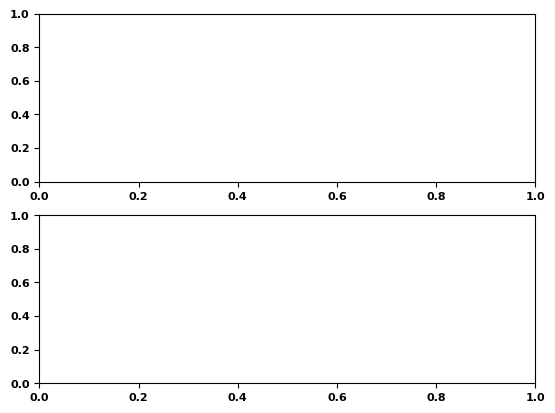

In [8]:
fig_phase,axs_phase = plt.subplots(2,1)
experiments = {'data_generation':'k', 'Control':'r'}#     computed_energy = compute_energy_consump(test_results[APP][tar_file]['power'])
print("Total Energy consumed: ", computed_energy)
print("Total Execution Time: ", test_results[APP][tar_file]['energy'].time.iloc[-1]-test_results[APP][tar_file]['energy'].time.iloc[0])
axs_phase[0].scatter(test_results[APP][tar_file]['progress']['progress_frequency_median']['elapsed_time'],test_results[APP][tar_file]['progress']['progress_frequency_median']['median'],color=experiments[dirs])
axs_phase[1].scatter(test_results[APP][tar_file]['power']['average_power']['elapsed_time'],test_results[APP][tar_file]['power']['average_power']['average_power'],color=experiments[dirs])
axs_phase[1].set_xlabel("Time [s]")
axs_phase[0].set_ylabel("Progress [s]")
axs_phase[1].set_ylabel("Measured Power [s]")
plt.savefig('phases.pdf', format='pdf', bbox_inches='tight') 